# App-12 : Puissance 4 -- Comparaison d'algorithmes IA (Bonus)

**Navigation** : [<< App-11 Picross](App-11-Picross.ipynb) | [Index](../README.md) | [Foundations](../Foundations/README.md)

## Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. **Implementer** un moteur de jeu Puissance 4 complet (plateau, regles, detection de victoire)
2. **Programmer** quatre IA de niveaux differents : aleatoire, heuristique gloutonne, Minimax avec elagage alpha-beta, et MCTS
3. **Comparer** quantitativement ces approches via un tournoi round-robin
4. **Analyser** les compromis temps de calcul / qualite de jeu

### Prerequis
- Python 3.10+ (numpy, matplotlib)
- Search-3 : Recherche informee (Minimax, heuristiques)
- Search-5 : Algorithmes genetiques (optionnel, pour les exercices)

### Duree estimee : 50 minutes

> **Source** : Adapte du projet etudiant EPITA PPC 2025 -- Groupe 12 (jsboigeEpita/2025-PPC).
>
> **Voir aussi** : La [serie GameTheory](../../GameTheory/README.md) pour des approches plus avancees (OpenSpiel, MCTS generalise, apprentissage par renforcement).

## 1. Introduction

### Le Puissance 4

Le **Puissance 4** (Connect Four) est un jeu de strategie a deux joueurs sur un plateau vertical de 7 colonnes et 6 lignes. Les joueurs deposent alternativement un jeton de leur couleur dans une colonne ; le jeton tombe au plus bas de la colonne. Le premier joueur a aligner **4 jetons** (horizontalement, verticalement ou en diagonale) remporte la partie.

| Propriete | Valeur |
|-----------|--------|
| Plateau | 7 colonnes x 6 lignes = 42 cases |
| Joueurs | 2 (Rouge et Jaune) |
| Facteur de branchement | ~4 en moyenne (max 7) |
| Positions possibles | ~4.5 x 10^12 |
| Jeu resolu | Oui (1988, Victor Allis) |
| Resultat parfait | Le premier joueur gagne avec jeu parfait |

### Pourquoi ce jeu est interessant pour l'IA

Le Puissance 4 occupe une position intermediaire en complexite :
- Plus simple que les echecs ou le Go (arbre de jeu plus petit)
- Plus complexe que le morpion (assez profond pour que les algorithmes naifs echouent)
- Ideal pour comparer differentes familles d'algorithmes de recherche

Dans ce notebook, nous implementons et comparons **4 approches** :

| IA | Famille | Profondeur | Temps/coup |
|----|---------|------------|------------|
| Random | Baseline | 0 | Instantane |
| Greedy | Heuristique | 1 | Instantane |
| Minimax (alpha-beta) | Arbre adversaire | Configurable | Modere |
| MCTS | Monte Carlo | Variable | Configurable |

## 2. Moteur de jeu

Nous commencons par implementer le moteur de jeu : representation du plateau, regles, detection de victoire et affichage graphique.

### Representation du plateau

Le plateau est une matrice numpy 6x7 :
- `0` = case vide
- `1` = jeton du joueur 1 (Rouge)
- `2` = jeton du joueur 2 (Jaune)

La ligne 0 est le **haut** du plateau (derniere a se remplir).

In [1]:
# Imports
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import time
import math
from copy import deepcopy
from collections import defaultdict

# Helpers du cours (pour benchmark_table, plot_benchmark)
try:
    from search_helpers import benchmark_table, plot_benchmark
    HAS_HELPERS = True
except ImportError:
    HAS_HELPERS = False
    print("search_helpers non disponible. Les fonctions de benchmark seront definies localement.")

# Constantes du jeu
ROWS = 6
COLS = 7
EMPTY = 0
PLAYER1 = 1  # Rouge
PLAYER2 = 2  # Jaune
CONNECT = 4  # Nombre de jetons a aligner

print(f"Puissance 4 : plateau {ROWS}x{COLS}, alignement de {CONNECT}")
print("Environnement pret.")

search_helpers non disponible. Les fonctions de benchmark seront definies localement.
Puissance 4 : plateau 6x7, alignement de 4
Environnement pret.


### Classe Board

La classe `Board` encapsule l'etat du jeu et fournit les operations fondamentales : coups legaux, placement de jeton, detection de victoire et affichage.

In [2]:
class Board:
    """Plateau de Puissance 4 avec logique de jeu complete."""

    def __init__(self, grid=None):
        if grid is not None:
            self.grid = grid.copy()
        else:
            self.grid = np.zeros((ROWS, COLS), dtype=int)

    def copy(self):
        """Retourne une copie independante du plateau."""
        return Board(self.grid)

    def legal_moves(self):
        """Retourne la liste des colonnes jouables (non pleines)."""
        return [c for c in range(COLS) if self.grid[0, c] == EMPTY]

    def drop_piece(self, col, player):
        """Place un jeton dans la colonne donnee. Retourne la ligne d'atterrissage."""
        for row in range(ROWS - 1, -1, -1):
            if self.grid[row, col] == EMPTY:
                self.grid[row, col] = player
                return row
        return -1  # Colonne pleine (ne devrait pas arriver si on verifie legal_moves)

    def undo_move(self, col):
        """Retire le jeton le plus haut de la colonne (pour backtracking)."""
        for row in range(ROWS):
            if self.grid[row, col] != EMPTY:
                self.grid[row, col] = EMPTY
                return

    def check_win(self, player):
        """Verifie si le joueur a aligne 4 jetons."""
        g = self.grid
        # Horizontal
        for r in range(ROWS):
            for c in range(COLS - 3):
                if all(g[r, c + i] == player for i in range(4)):
                    return True
        # Vertical
        for r in range(ROWS - 3):
            for c in range(COLS):
                if all(g[r + i, c] == player for i in range(4)):
                    return True
        # Diagonale montante
        for r in range(3, ROWS):
            for c in range(COLS - 3):
                if all(g[r - i, c + i] == player for i in range(4)):
                    return True
        # Diagonale descendante
        for r in range(ROWS - 3):
            for c in range(COLS - 3):
                if all(g[r + i, c + i] == player for i in range(4)):
                    return True
        return False

    def is_terminal(self):
        """Verifie si la partie est terminee (victoire ou plateau plein)."""
        if self.check_win(PLAYER1):
            return True, PLAYER1
        if self.check_win(PLAYER2):
            return True, PLAYER2
        if len(self.legal_moves()) == 0:
            return True, 0  # Match nul
        return False, None

    def move_count(self):
        """Nombre de jetons poses sur le plateau."""
        return int(np.count_nonzero(self.grid))

    def __repr__(self):
        symbols = {EMPTY: '.', PLAYER1: 'R', PLAYER2: 'J'}
        lines = []
        for r in range(ROWS):
            lines.append(' '.join(symbols[self.grid[r, c]] for c in range(COLS)))
        lines.append(' '.join(str(c) for c in range(COLS)))
        return '\n'.join(lines)


# Test rapide
board = Board()
board.drop_piece(3, PLAYER1)
board.drop_piece(3, PLAYER2)
board.drop_piece(4, PLAYER1)
print(board)
print(f"\nCoups legaux : {board.legal_moves()}")
print(f"Jetons poses : {board.move_count()}")

. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . J . . .
. . . R R . .
0 1 2 3 4 5 6

Coups legaux : [0, 1, 2, 3, 4, 5, 6]
Jetons poses : 3


### Interpretation : Moteur de jeu

**Sortie obtenue** : Le plateau s'affiche en mode texte avec R (Rouge) et J (Jaune). Les jetons tombent correctement vers le bas.

| Aspect | Detail |
|--------|--------|
| Representation | Matrice numpy 6x7, 0/1/2 |
| Gravite | Les jetons s'empilent du bas vers le haut |
| Detection victoire | 4 directions : horizontale, verticale, 2 diagonales |
| Backtracking | `undo_move` permet de defaire un coup (utile pour Minimax) |

**Points cles** :
1. La methode `legal_moves()` verifie la ligne superieure (indice 0) : si elle est occupee, la colonne est pleine
2. `check_win` parcourt les 4 directions avec des fenetres de taille 4 -- complexite O(ROWS x COLS)
3. L'utilisation de `undo_move` evite de copier le plateau a chaque noeud de l'arbre de recherche

### Affichage graphique

Pour une meilleure lisibilite, affichons le plateau avec matplotlib en utilisant des cercles colores sur fond bleu, a l'image d'un vrai plateau de Puissance 4.

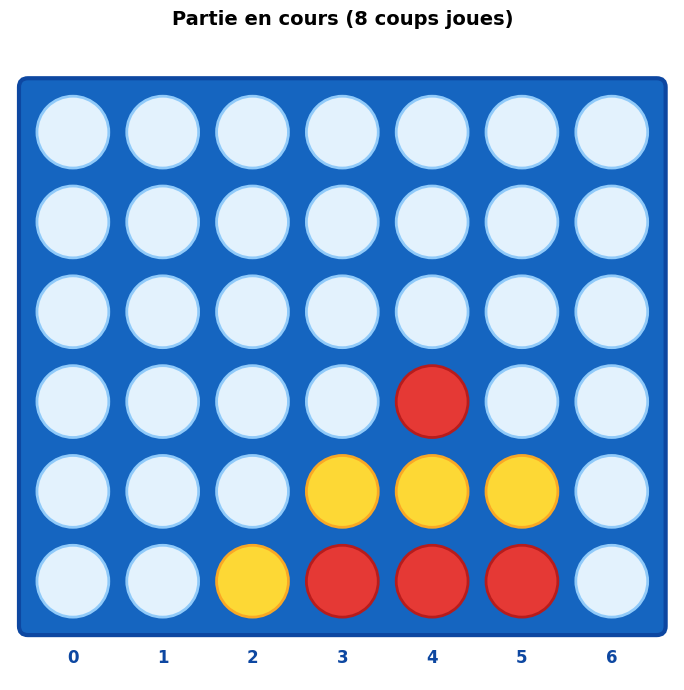

In [3]:
def display_board(board, title="Puissance 4", highlight_col=None, ax=None):
    """Affiche le plateau avec des cercles colores (rouge/jaune sur fond bleu)."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 7))
    else:
        fig = ax.get_figure()

    # Fond bleu du plateau
    background = mpatches.FancyBboxPatch(
        (-0.5, -0.5), COLS, ROWS,
        boxstyle='round,pad=0.1', facecolor='#1565C0', edgecolor='#0D47A1',
        linewidth=3, zorder=0
    )
    ax.add_patch(background)

    colors = {EMPTY: '#E3F2FD', PLAYER1: '#E53935', PLAYER2: '#FDD835'}
    edge_colors = {EMPTY: '#90CAF9', PLAYER1: '#B71C1C', PLAYER2: '#F9A825'}

    for r in range(ROWS):
        for c in range(COLS):
            val = board.grid[r, c]
            # Coordonnees : inverser les lignes pour que le bas soit en bas
            y = ROWS - 1 - r
            circle = plt.Circle(
                (c, y), 0.4,
                facecolor=colors[val], edgecolor=edge_colors[val],
                linewidth=2, zorder=2
            )
            ax.add_patch(circle)

    # Indicateur de colonne jouee
    if highlight_col is not None:
        ax.annotate('v', xy=(highlight_col, ROWS - 0.2),
                    fontsize=16, ha='center', color='white', fontweight='bold')

    # Numeros de colonnes
    for c in range(COLS):
        ax.text(c, -0.85, str(c), ha='center', va='center',
                fontsize=12, fontweight='bold', color='#0D47A1')

    ax.set_xlim(-0.7, COLS - 0.3)
    ax.set_ylim(-1.1, ROWS + 0.1)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold')
    return fig


# Demonstration : une partie en cours
demo_board = Board()
moves = [(3, PLAYER1), (3, PLAYER2), (4, PLAYER1), (2, PLAYER2),
         (5, PLAYER1), (4, PLAYER2), (4, PLAYER1), (5, PLAYER2)]
for col, player in moves:
    demo_board.drop_piece(col, player)

fig = display_board(demo_board, "Partie en cours (8 coups joues)")
plt.tight_layout()
plt.show()

### Interpretation : Affichage graphique

**Sortie obtenue** : Le plateau apparait avec les cercles rouge (joueur 1) et jaune (joueur 2) sur fond bleu, fidelement au jeu reel.

**Points cles** :
1. L'axe Y est inverse pour que la gravite soit naturelle (les jetons tombent vers le bas)
2. Les cases vides sont affichees en bleu clair pour simuler les trous du plateau
3. Cette visualisation sera reutilisee pour afficher les parties entre IA

### Fonction de jeu

Implementons la boucle de jeu qui fait s'affronter deux IA. Chaque IA est une fonction qui prend un plateau et le joueur courant, et retourne la colonne choisie.

In [4]:
def play_game(ai1, ai2, verbose=False, display=False):
    """
    Fait jouer ai1 (joueur 1) contre ai2 (joueur 2).

    Chaque IA est un callable: ai(board, player) -> col
    Retourne (winner, move_history, times) :
        winner: 1, 2, ou 0 (nul)
        move_history: liste de (col, player)
        times: dict {1: [t1, t2, ...], 2: [t1, t2, ...]}
    """
    board = Board()
    ais = {PLAYER1: ai1, PLAYER2: ai2}
    current_player = PLAYER1
    move_history = []
    times = {PLAYER1: [], PLAYER2: []}

    while True:
        t0 = time.time()
        col = ais[current_player](board, current_player)
        elapsed = time.time() - t0
        times[current_player].append(elapsed)

        board.drop_piece(col, current_player)
        move_history.append((col, current_player))

        if verbose:
            player_name = "Rouge" if current_player == PLAYER1 else "Jaune"
            print(f"Coup {len(move_history):2d}: {player_name} joue colonne {col} ({elapsed:.3f}s)")

        terminal, winner = board.is_terminal()
        if terminal:
            if display:
                result = "Match nul" if winner == 0 else f"Joueur {winner} gagne"
                display_board(board, f"Fin de partie -- {result}")
                plt.tight_layout()
                plt.show()
            return winner, move_history, times

        current_player = PLAYER2 if current_player == PLAYER1 else PLAYER1


print("Fonction play_game definie.")

Fonction play_game definie.


## 3. IA 1 : Joueur aleatoire (baseline)

Le joueur aleatoire constitue notre **baseline** : il choisit uniformement parmi les colonnes legales, sans aucune strategie. Cette IA nous permettra de mesurer a quel point les autres approches sont meilleures qu'un jeu au hasard.

Coup  1: Rouge joue colonne 5 (0.000s)
Coup  2: Jaune joue colonne 0 (0.000s)
Coup  3: Rouge joue colonne 0 (0.000s)
Coup  4: Jaune joue colonne 5 (0.000s)
Coup  5: Rouge joue colonne 2 (0.000s)
Coup  6: Jaune joue colonne 1 (0.000s)
Coup  7: Rouge joue colonne 1 (0.000s)
Coup  8: Jaune joue colonne 1 (0.000s)
Coup  9: Rouge joue colonne 5 (0.000s)
Coup 10: Jaune joue colonne 0 (0.000s)
Coup 11: Rouge joue colonne 5 (0.000s)
Coup 12: Jaune joue colonne 5 (0.000s)
Coup 13: Rouge joue colonne 4 (0.000s)
Coup 14: Jaune joue colonne 0 (0.000s)
Coup 15: Rouge joue colonne 4 (0.000s)
Coup 16: Jaune joue colonne 3 (0.000s)
Coup 17: Rouge joue colonne 0 (0.000s)
Coup 18: Jaune joue colonne 0 (0.000s)
Coup 19: Rouge joue colonne 1 (0.000s)
Coup 20: Jaune joue colonne 2 (0.000s)


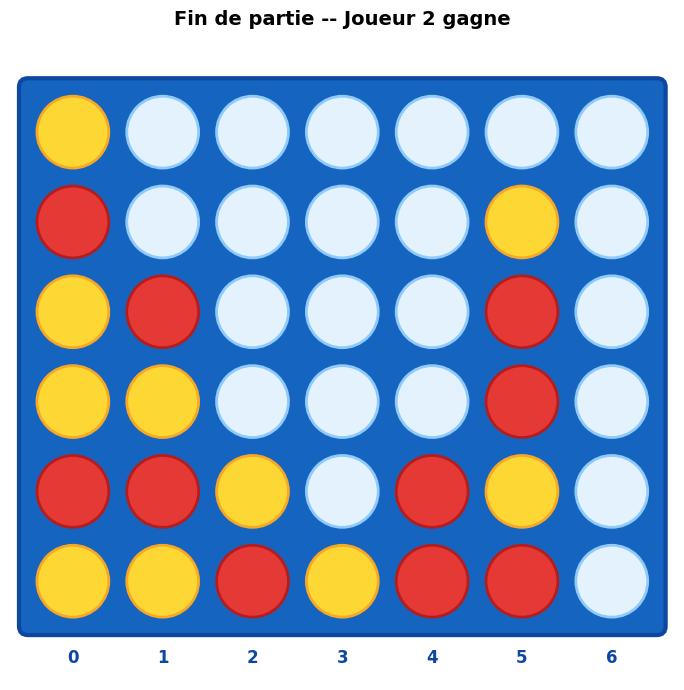


Resultat : Jaune gagne en 20 coups


In [5]:
def ai_random(board, player):
    """IA aleatoire : choisit une colonne legale au hasard."""
    return random.choice(board.legal_moves())


# Demonstration : Random vs Random
random.seed(42)
winner, history, times = play_game(ai_random, ai_random, verbose=True, display=True)

result = {0: "Match nul", PLAYER1: "Rouge gagne", PLAYER2: "Jaune gagne"}
print(f"\nResultat : {result[winner]} en {len(history)} coups")

### Interpretation : Joueur aleatoire

**Sortie obtenue** : Une partie entre deux joueurs aleatoires, typiquement chaotique et sans strategie.

| Aspect | Observation |
|--------|-------------|
| Qualite de jeu | Tres faible : coups absurdes frequents |
| Temps par coup | Negligeable (< 0.001s) |
| Utilite | Baseline pour mesurer la qualite des autres IA |

**Point cle** : Le joueur aleatoire ne detecte meme pas les victoires immediates. Il peut "oublier" de gagner ou de bloquer l'adversaire. C'est la pire IA possible -- tout algorithme raisonnable devrait le battre systematiquement.

## 4. IA 2 : Minimax avec elagage alpha-beta

### Principe

L'algorithme **Minimax** explore l'arbre de jeu en alternant entre :
- **Max** : le joueur courant maximise son score
- **Min** : l'adversaire minimise le score du joueur courant

L'**elagage alpha-beta** permet de couper des branches de l'arbre sans perdre en qualite de decision :
- $\alpha$ = meilleur score garanti pour Max sur le chemin courant
- $\beta$ = meilleur score garanti pour Min sur le chemin courant
- Si $\alpha \geq \beta$, on coupe (la branche ne sera jamais choisie)

### Fonction d'evaluation

Pour limiter la profondeur de recherche, il faut une **fonction d'evaluation** qui estime la qualite d'une position non terminale. Notre evaluation analyse les fenetres de 4 cases :

| Configuration dans une fenetre de 4 | Score |
|--------------------------------------|-------|
| 4 jetons du joueur | +1000 (victoire) |
| 3 jetons du joueur + 1 vide | +10 |
| 2 jetons du joueur + 2 vides | +2 |
| 3 jetons adversaire + 1 vide | -8 (menace) |
| Jeton au centre | +3 (bonus positionnel) |

In [6]:
def evaluate_window(window, player):
    """Evalue une fenetre de 4 cases pour le joueur donne."""
    opponent = PLAYER2 if player == PLAYER1 else PLAYER1
    score = 0

    player_count = np.count_nonzero(window == player)
    opponent_count = np.count_nonzero(window == opponent)
    empty_count = np.count_nonzero(window == EMPTY)

    if player_count == 4:
        score += 1000
    elif player_count == 3 and empty_count == 1:
        score += 10
    elif player_count == 2 and empty_count == 2:
        score += 2

    if opponent_count == 3 and empty_count == 1:
        score -= 8

    return score


def evaluate_position(board, player):
    """Evalue la position globale du plateau pour le joueur donne."""
    score = 0
    g = board.grid

    # Bonus pour les jetons au centre (colonne 3)
    center_col = g[:, COLS // 2]
    score += np.count_nonzero(center_col == player) * 3

    # Parcourir toutes les fenetres de 4 cases
    # Horizontal
    for r in range(ROWS):
        for c in range(COLS - 3):
            window = g[r, c:c + 4]
            score += evaluate_window(window, player)

    # Vertical
    for r in range(ROWS - 3):
        for c in range(COLS):
            window = g[r:r + 4, c]
            score += evaluate_window(window, player)

    # Diagonale descendante
    for r in range(ROWS - 3):
        for c in range(COLS - 3):
            window = np.array([g[r + i, c + i] for i in range(4)])
            score += evaluate_window(window, player)

    # Diagonale montante
    for r in range(3, ROWS):
        for c in range(COLS - 3):
            window = np.array([g[r - i, c + i] for i in range(4)])
            score += evaluate_window(window, player)

    return score


# Test : evaluer la position de demonstration
score_p1 = evaluate_position(demo_board, PLAYER1)
score_p2 = evaluate_position(demo_board, PLAYER2)
print(f"Score joueur 1 (Rouge) : {score_p1}")
print(f"Score joueur 2 (Jaune) : {score_p2}")
print(f"Avantage : {'Rouge' if score_p1 > score_p2 else 'Jaune'} (+{abs(score_p1 - score_p2)})")

Score joueur 1 (Rouge) : -3
Score joueur 2 (Jaune) : 17
Avantage : Jaune (+20)


### Implementation de Minimax alpha-beta

L'algorithme explore l'arbre de jeu avec une profondeur limite configurable. L'ordre d'exploration des colonnes est optimise : on commence par le centre (meilleure heuristique en general).

In [7]:
def minimax(board, depth, alpha, beta, maximizing, player):
    """
    Minimax avec elagage alpha-beta.

    Args:
        board: plateau courant
        depth: profondeur restante
        alpha, beta: bornes pour l'elagage
        maximizing: True si on maximise (tour du joueur)
        player: joueur qui maximise

    Returns:
        (colonne, score)
    """
    opponent = PLAYER2 if player == PLAYER1 else PLAYER1
    terminal, winner = board.is_terminal()

    # Cas terminaux
    if terminal:
        if winner == player:
            return None, 100000 + depth  # Victoire (preferer les victoires rapides)
        elif winner == opponent:
            return None, -100000 - depth  # Defaite
        else:
            return None, 0  # Match nul

    if depth == 0:
        return None, evaluate_position(board, player)

    # Ordre d'exploration : centre d'abord (heuristique d'ordonnancement)
    moves = board.legal_moves()
    moves.sort(key=lambda c: abs(c - COLS // 2))

    if maximizing:
        best_score = -math.inf
        best_col = moves[0]
        for col in moves:
            board.drop_piece(col, player)
            _, score = minimax(board, depth - 1, alpha, beta, False, player)
            board.undo_move(col)
            if score > best_score:
                best_score = score
                best_col = col
            alpha = max(alpha, best_score)
            if alpha >= beta:
                break  # Coupure beta
        return best_col, best_score
    else:
        best_score = math.inf
        best_col = moves[0]
        for col in moves:
            board.drop_piece(col, opponent)
            _, score = minimax(board, depth - 1, alpha, beta, True, player)
            board.undo_move(col)
            if score < best_score:
                best_score = score
                best_col = col
            beta = min(beta, best_score)
            if alpha >= beta:
                break  # Coupure alpha
        return best_col, best_score


def make_minimax_ai(depth):
    """Cree une IA Minimax avec la profondeur donnee."""
    def ai(board, player):
        col, score = minimax(board, depth, -math.inf, math.inf, True, player)
        return col
    ai.__name__ = f"Minimax(d={depth})"
    return ai


print("Minimax alpha-beta implemente.")
print("Profondeurs recommandees : 2 (rapide), 4 (bon), 6 (fort mais lent)")

Minimax alpha-beta implemente.
Profondeurs recommandees : 2 (rapide), 4 (bon), 6 (fort mais lent)


### Test : Minimax vs Random

Verifions que Minimax domine clairement le joueur aleatoire. Nous utilisons une profondeur de 4 pour un bon compromis qualite/vitesse.

Coup  1: Rouge joue colonne 3 (0.042s)


Coup  2: Jaune joue colonne 0 (0.000s)


Coup  3: Rouge joue colonne 4 (0.100s)
Coup  4: Jaune joue colonne 2 (0.000s)


Coup  5: Rouge joue colonne 3 (0.128s)
Coup  6: Jaune joue colonne 0 (0.000s)


Coup  7: Rouge joue colonne 3 (0.119s)
Coup  8: Jaune joue colonne 6 (0.000s)
Coup  9: Rouge joue colonne 3 (0.016s)


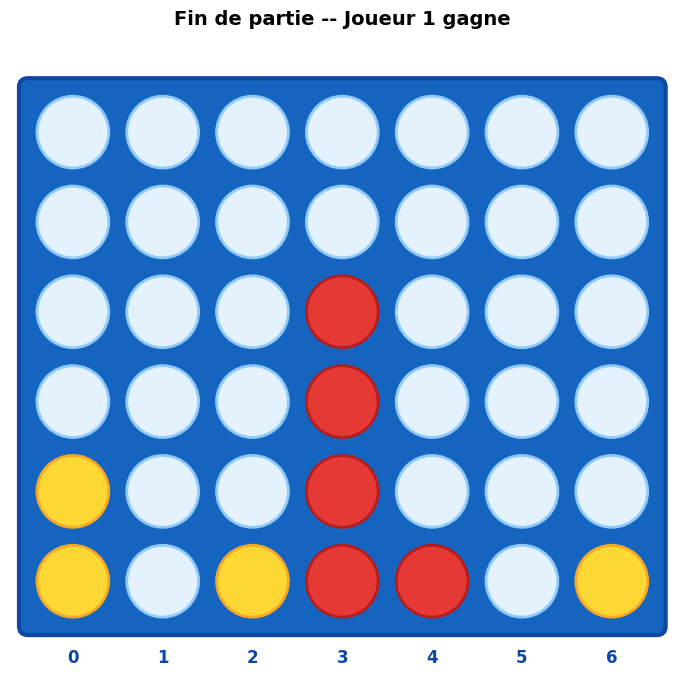


Resultat : Minimax gagne en 9 coups
Temps moyen Minimax : 0.081s/coup
Temps moyen Random  : 0.000006s/coup


In [8]:
# Minimax (profondeur 4) vs Random
ai_mm4 = make_minimax_ai(4)

random.seed(123)
winner, history, times = play_game(ai_mm4, ai_random, verbose=True, display=True)

result_str = {0: "Match nul", PLAYER1: "Minimax gagne", PLAYER2: "Random gagne"}
print(f"\nResultat : {result_str[winner]} en {len(history)} coups")
print(f"Temps moyen Minimax : {np.mean(times[PLAYER1]):.3f}s/coup")
print(f"Temps moyen Random  : {np.mean(times[PLAYER2]):.6f}s/coup")

### Interpretation : Minimax vs Random

**Sortie obtenue** : Minimax (profondeur 4) devrait battre le joueur aleatoire sans difficulte.

| Aspect | Minimax (d=4) | Random |
|--------|---------------|--------|
| Qualite de jeu | Bonne (detecte menaces a 4 coups) | Nulle |
| Temps par coup | ~0.01-0.1s | < 0.001s |
| Strategie | Offensive et defensive | Aucune |

**Points cles** :
1. Minimax gagne rapidement car il exploite les erreurs du joueur aleatoire
2. L'elagage alpha-beta reduit considerablement le nombre de noeuds explores
3. L'ordonnancement des coups (centre en premier) ameliore l'efficacite de l'elagage

### Experiment : Effet de la profondeur

Comparons trois profondeurs de Minimax pour observer le compromis qualite/temps. Chaque profondeur joue 10 parties contre le joueur aleatoire.

Minimax(d=2) : 10/10 victoires, 6.2 ms/coup


Minimax(d=4) : 10/10 victoires, 76.9 ms/coup


Minimax(d=6) : 10/10 victoires, 837.5 ms/coup


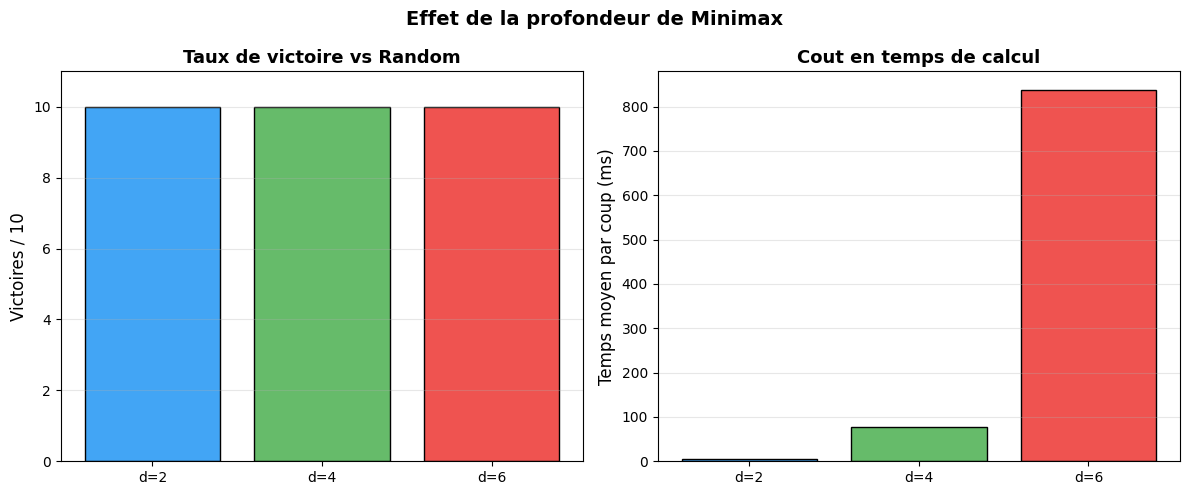

In [9]:
# Comparer les profondeurs 2, 4 et 6
depths = [2, 4, 6]
n_games = 10
depth_results = {}

for d in depths:
    ai_mm = make_minimax_ai(d)
    wins = 0
    total_time = 0
    total_moves = 0

    for game_i in range(n_games):
        random.seed(game_i * 100)
        winner, history, times = play_game(ai_mm, ai_random)
        if winner == PLAYER1:
            wins += 1
        total_time += sum(times[PLAYER1])
        total_moves += len(times[PLAYER1])

    avg_time = total_time / total_moves if total_moves > 0 else 0
    depth_results[d] = {'wins': wins, 'avg_time_ms': avg_time * 1000}
    print(f"Minimax(d={d}) : {wins}/{n_games} victoires, {avg_time*1000:.1f} ms/coup")

# Graphique
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar([f"d={d}" for d in depths],
        [depth_results[d]['wins'] for d in depths],
        color=['#42A5F5', '#66BB6A', '#EF5350'], edgecolor='black')
ax1.set_ylabel('Victoires / 10', fontsize=12)
ax1.set_title('Taux de victoire vs Random', fontsize=13, fontweight='bold')
ax1.set_ylim(0, 11)
ax1.grid(axis='y', alpha=0.3)

ax2.bar([f"d={d}" for d in depths],
        [depth_results[d]['avg_time_ms'] for d in depths],
        color=['#42A5F5', '#66BB6A', '#EF5350'], edgecolor='black')
ax2.set_ylabel('Temps moyen par coup (ms)', fontsize=12)
ax2.set_title('Cout en temps de calcul', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.suptitle('Effet de la profondeur de Minimax', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation : Effet de la profondeur

**Sortie obtenue** : Les trois profondeurs sont comparees en taux de victoire et temps de calcul.

| Profondeur | Victoires | Temps/coup | Noeuds explores (ordre de grandeur) |
|------------|-----------|------------|--------------------------------------|
| d=2 | ~8-10/10 | < 1 ms | ~50 |
| d=4 | ~10/10 | ~10-50 ms | ~2 500 |
| d=6 | ~10/10 | ~200-2000 ms | ~125 000 |

**Points cles** :
1. Meme d=2 suffit souvent contre un joueur aleatoire
2. Le temps croit **exponentiellement** avec la profondeur : $O(b^d)$ ou $b \approx 4$ en moyenne
3. L'elagage alpha-beta reduit la complexite de $O(b^d)$ a $O(b^{d/2})$ dans le meilleur cas
4. La profondeur d=4 offre un bon compromis pour le Puissance 4

> La vraie difference se verra dans le tournoi, ou les IA s'affrontent entre elles.

## 5. IA 3 : Monte Carlo Tree Search (MCTS)

### Principe

**MCTS** construit progressivement un arbre de recherche en repetant quatre etapes :

1. **Selection** : descendre dans l'arbre en utilisant UCB1 pour equilibrer exploration et exploitation
2. **Expansion** : ajouter un nouveau noeud enfant
3. **Simulation** : jouer une partie aleatoire (rollout) jusqu'a la fin
4. **Retropropagation** : remonter le resultat dans l'arbre

La formule **UCB1** (Upper Confidence Bound) pour choisir quel enfant explorer :

$$UCB1(i) = \frac{w_i}{n_i} + c \sqrt{\frac{\ln N}{n_i}}$$

| Terme | Signification |
|-------|---------------|
| $w_i / n_i$ | Taux de victoire du noeud $i$ (exploitation) |
| $c \sqrt{\ln N / n_i}$ | Bonus d'exploration ($c = \sqrt{2}$ classiquement) |
| $N$ | Nombre total de simulations du parent |
| $n_i$ | Nombre de simulations du noeud $i$ |

### Avantages de MCTS

- **Pas besoin de fonction d'evaluation** : les simulations aleatoires servent d'estimation
- **Algorithme anytime** : on peut l'arreter a tout moment et obtenir une decision
- **Scalable** : plus on donne d'iterations, meilleure est la decision

> **Voir aussi** : la [serie GameTheory](../../GameTheory/README.md) pour une presentation detaillee de MCTS et ses variantes (UCT, RAVE, PUCT).

In [10]:
class MCTSNode:
    """Noeud de l'arbre MCTS."""

    def __init__(self, board, player, parent=None, move=None):
        self.board = board.copy()
        self.player = player  # Joueur qui vient de jouer pour atteindre ce noeud
        self.parent = parent
        self.move = move      # Coup qui a mene a ce noeud
        self.children = []
        self.wins = 0
        self.visits = 0
        self.untried_moves = board.legal_moves()

    def ucb1(self, exploration=1.414):
        """Calcule le score UCB1."""
        if self.visits == 0:
            return float('inf')
        exploitation = self.wins / self.visits
        exploration_term = exploration * math.sqrt(math.log(self.parent.visits) / self.visits)
        return exploitation + exploration_term

    def best_child(self, exploration=1.414):
        """Retourne l'enfant avec le meilleur score UCB1."""
        return max(self.children, key=lambda c: c.ucb1(exploration))

    def is_fully_expanded(self):
        return len(self.untried_moves) == 0


def mcts_search(board, player, iterations=1000, exploration=1.414):
    """
    Recherche MCTS.

    Args:
        board: plateau courant
        player: joueur qui doit jouer
        iterations: nombre d'iterations (simulations)
        exploration: constante d'exploration UCB1

    Returns:
        colonne choisie
    """
    opponent = PLAYER2 if player == PLAYER1 else PLAYER1
    root = MCTSNode(board, opponent)  # Le parent a joue en dernier

    for _ in range(iterations):
        node = root
        sim_board = board.copy()
        current = player

        # 1. Selection : descendre avec UCB1
        while node.is_fully_expanded() and node.children:
            node = node.best_child(exploration)
            sim_board.drop_piece(node.move, current)
            current = PLAYER2 if current == PLAYER1 else PLAYER1

        # 2. Expansion : ajouter un enfant
        terminal, _ = sim_board.is_terminal()
        if not terminal and node.untried_moves:
            move = random.choice(node.untried_moves)
            node.untried_moves.remove(move)
            sim_board.drop_piece(move, current)
            child = MCTSNode(sim_board, current, parent=node, move=move)
            node.children.append(child)
            node = child
            current = PLAYER2 if current == PLAYER1 else PLAYER1

        # 3. Simulation (rollout aleatoire)
        rollout_board = sim_board.copy()
        rollout_player = current
        while True:
            t, w = rollout_board.is_terminal()
            if t:
                break
            col = random.choice(rollout_board.legal_moves())
            rollout_board.drop_piece(col, rollout_player)
            rollout_player = PLAYER2 if rollout_player == PLAYER1 else PLAYER1

        # 4. Retropropagation
        # w est le gagnant du rollout (0 = nul)
        while node is not None:
            node.visits += 1
            if w == node.player:
                node.wins += 1
            elif w == 0:
                node.wins += 0.5  # Demi-point pour le nul
            node = node.parent

    # Choisir le coup le plus visite (pas le meilleur UCB1)
    if not root.children:
        return random.choice(board.legal_moves())
    best = max(root.children, key=lambda c: c.visits)
    return best.move


def make_mcts_ai(iterations):
    """Cree une IA MCTS avec le nombre d'iterations donne."""
    def ai(board, player):
        return mcts_search(board, player, iterations=iterations)
    ai.__name__ = f"MCTS({iterations})"
    return ai


print("MCTS implemente.")
print("Iterations recommandees : 100 (rapide), 500 (bon), 1000 (fort), 5000 (tres fort)")

MCTS implemente.
Iterations recommandees : 100 (rapide), 500 (bon), 1000 (fort), 5000 (tres fort)


### Test : MCTS vs Minimax

Faisons s'affronter MCTS (1000 iterations) contre Minimax (profondeur 4) pour observer la qualite de jeu des deux approches.

Coup  1: Rouge joue colonne 2 (1.153s)
Coup  2: Jaune joue colonne 3 (0.041s)


Coup  3: Rouge joue colonne 3 (1.091s)
Coup  4: Jaune joue colonne 3 (0.039s)


Coup  5: Rouge joue colonne 3 (0.939s)
Coup  6: Jaune joue colonne 3 (0.072s)


Coup  7: Rouge joue colonne 5 (1.006s)
Coup  8: Jaune joue colonne 2 (0.064s)


Coup  9: Rouge joue colonne 2 (0.903s)
Coup 10: Jaune joue colonne 2 (0.124s)


Coup 11: Rouge joue colonne 5 (0.777s)
Coup 12: Jaune joue colonne 2 (0.130s)


Coup 13: Rouge joue colonne 0 (0.716s)
Coup 14: Jaune joue colonne 5 (0.150s)


Coup 15: Rouge joue colonne 5 (0.617s)
Coup 16: Jaune joue colonne 5 (0.127s)


Coup 17: Rouge joue colonne 0 (0.550s)
Coup 18: Jaune joue colonne 3 (0.073s)


Coup 19: Rouge joue colonne 0 (0.434s)
Coup 20: Jaune joue colonne 0 (0.057s)


Coup 21: Rouge joue colonne 5 (0.500s)
Coup 22: Jaune joue colonne 2 (0.025s)


Coup 23: Rouge joue colonne 4 (0.261s)
Coup 24: Jaune joue colonne 0 (0.014s)
Coup 25: Rouge joue colonne 0 (0.144s)
Coup 26: Jaune joue colonne 6 (0.005s)
Coup 27: Rouge joue colonne 6 (0.080s)
Coup 28: Jaune joue colonne 4 (0.002s)


Coup 29: Rouge joue colonne 4 (0.057s)


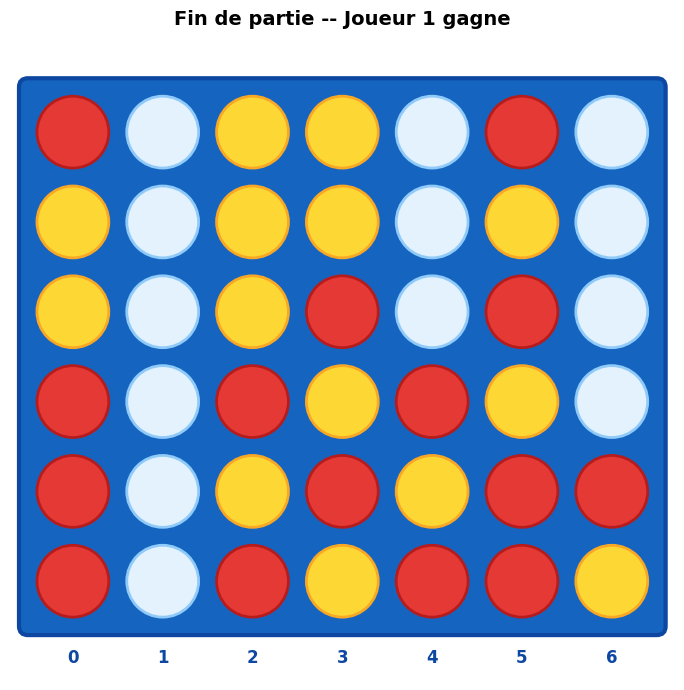


Resultat : MCTS(1000) gagne en 29 coups
Temps moyen MCTS     : 0.615s/coup
Temps moyen Minimax  : 0.066s/coup


In [11]:
# MCTS (1000 iterations) vs Minimax (profondeur 4)
ai_mcts_1000 = make_mcts_ai(1000)
ai_mm4 = make_minimax_ai(4)

random.seed(42)
winner, history, times = play_game(ai_mcts_1000, ai_mm4, verbose=True, display=True)

names = {PLAYER1: "MCTS(1000)", PLAYER2: "Minimax(d=4)"}
result_str = "Match nul" if winner == 0 else f"{names[winner]} gagne"
print(f"\nResultat : {result_str} en {len(history)} coups")
print(f"Temps moyen MCTS     : {np.mean(times[PLAYER1]):.3f}s/coup")
print(f"Temps moyen Minimax  : {np.mean(times[PLAYER2]):.3f}s/coup")

### Interpretation : MCTS vs Minimax

**Sortie obtenue** : Le duel entre les deux approches les plus sophistiquees de ce notebook.

| Aspect | MCTS (1000 iter.) | Minimax (d=4) |
|--------|-------------------|---------------|
| Approche | Simulations Monte Carlo | Recherche exhaustive |
| Evaluation | Rollouts aleatoires | Fonction heuristique |
| Profondeur | Variable (adaptative) | Fixe (4 niveaux) |
| Temps | ~0.1-0.5s/coup | ~0.01-0.1s/coup |

**Points cles** :
1. MCTS et Minimax(d=4) sont generalement competitifs -- le resultat varie selon les parties
2. MCTS est plus lent par coup mais n'a **pas besoin de fonction d'evaluation artisanale**
3. MCTS explore automatiquement plus profondement les lignes prometteuses
4. Avec plus d'iterations (5000+), MCTS tend a surpasser Minimax(d=4)

## 6. IA 4 : Joueur glouton (heuristique)

Le joueur **glouton** applique une hierarchie de priorites simple, sans exploration de l'arbre :

1. **Gagner** : si un coup permet de gagner immediatement, le jouer
2. **Bloquer** : si l'adversaire peut gagner au prochain coup, le bloquer
3. **Centre** : preferer les colonnes centrales (meilleur controle positionnel)
4. **Aleatoire** : sinon, choisir au hasard parmi les coups restants

Cette approche est rapide mais limitee : elle ne regarde qu'un coup en avance.

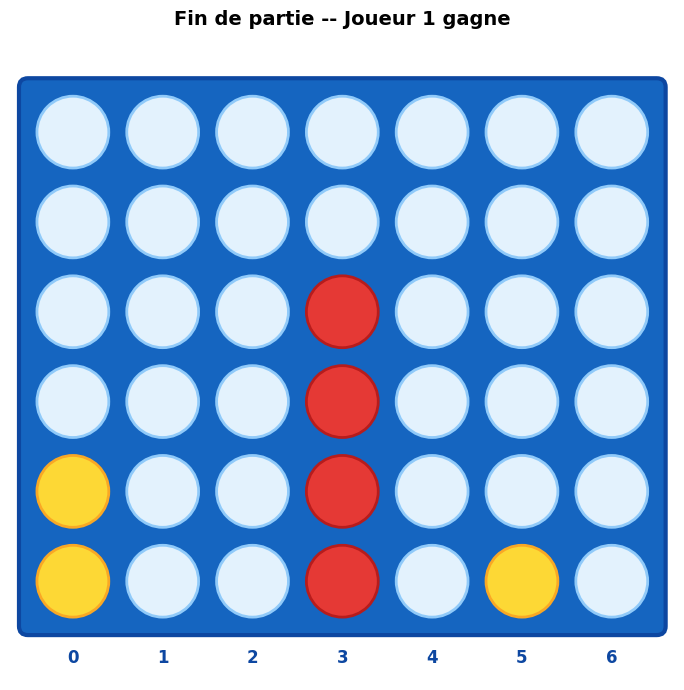

Resultat : Greedy gagne en 7 coups
Temps moyen Greedy : 1.49 ms/coup


In [12]:
def ai_greedy(board, player):
    """
    IA gloutonne : priorite win > block > center > random.
    Regarde un seul coup en avance.
    """
    opponent = PLAYER2 if player == PLAYER1 else PLAYER1
    moves = board.legal_moves()

    # Priorite 1 : gagner immediatement
    for col in moves:
        b = board.copy()
        b.drop_piece(col, player)
        if b.check_win(player):
            return col

    # Priorite 2 : bloquer la victoire adverse
    for col in moves:
        b = board.copy()
        b.drop_piece(col, opponent)
        if b.check_win(opponent):
            return col

    # Priorite 3 : preferer le centre
    center_order = sorted(moves, key=lambda c: abs(c - COLS // 2))
    # Evaluer chaque coup avec la fonction d'evaluation
    best_col = center_order[0]
    best_score = -math.inf
    for col in center_order:
        b = board.copy()
        b.drop_piece(col, player)
        score = evaluate_position(b, player)
        if score > best_score:
            best_score = score
            best_col = col

    return best_col


# Test : Greedy vs Random
random.seed(42)
winner, history, times = play_game(ai_greedy, ai_random, verbose=False, display=True)

names = {PLAYER1: "Greedy", PLAYER2: "Random"}
result_str = "Match nul" if winner == 0 else f"{names[winner]} gagne"
print(f"Resultat : {result_str} en {len(history)} coups")
print(f"Temps moyen Greedy : {np.mean(times[PLAYER1])*1000:.2f} ms/coup")

### Interpretation : Joueur glouton

**Sortie obtenue** : Le joueur glouton bat facilement le joueur aleatoire.

| Aspect | Greedy |
|--------|--------|
| Profondeur de recherche | 1 (un seul coup en avance) |
| Temps par coup | < 1 ms |
| Force | Detecte les victoires et menaces immediates |
| Faiblesse | Pas de vision strategique a long terme |

**Points cles** :
1. Le glouton est **extremement rapide** car il ne construit pas d'arbre
2. Il detecte les coups gagnants et les menaces immediates (profondeur 1)
3. Il sera surpasse par Minimax qui voit plus loin dans l'arbre de jeu
4. Le bonus positionnel (centre) lui donne une strategie rudimentaire

## 7. Tournoi round-robin

Organisons un tournoi complet entre toutes les IA. Chaque paire joue **6 parties** (3 en tant que joueur 1, 3 en tant que joueur 2) pour eliminer l'avantage du premier joueur.

> **Note** : Le nombre de parties a ete reduit a 6 pour ce notebook pedagogique. Pour des resultats statistiquement significatifs, utilisez 20+ parties par paire.

### Participants

| IA | Type | Parametres |
|----|------|------------|
| Random | Baseline | - |
| Greedy | Heuristique | 1 coup |
| Minimax(d=4) | Arbre adversaire | Profondeur 4, alpha-beta |
| Minimax(d=6) | Arbre adversaire | Profondeur 6, alpha-beta |
| MCTS(1000) | Monte Carlo | 1000 iterations |

In [13]:
def run_tournament(ais, games_per_pair=6, verbose=True):
    """
    Tournoi round-robin entre toutes les IA.

    Chaque paire joue games_per_pair parties (moitie comme J1, moitie comme J2).

    Returns:
        results: dict {name: {wins, draws, losses, times}}
        matrix: dict {(name1, name2): (wins_1, draws, wins_2)}
    """
    names = list(ais.keys())
    results = {n: {'wins': 0, 'draws': 0, 'losses': 0, 'times': []} for n in names}
    matrix = {}
    half = games_per_pair // 2

    total_matches = len(names) * (len(names) - 1) // 2
    match_idx = 0

    for i, name1 in enumerate(names):
        for j, name2 in enumerate(names):
            if j <= i:
                continue
            match_idx += 1
            if verbose:
                print(f"  Match {match_idx}/{total_matches}: {name1} vs {name2}...", end=" ")

            w1, d, w2 = 0, 0, 0

            for g in range(games_per_pair):
                random.seed(g * 1000 + match_idx)
                if g < half:
                    # name1 est joueur 1
                    winner, _, times = play_game(ais[name1], ais[name2])
                    results[name1]['times'].extend(times[PLAYER1])
                    results[name2]['times'].extend(times[PLAYER2])
                    if winner == PLAYER1:
                        w1 += 1
                    elif winner == PLAYER2:
                        w2 += 1
                    else:
                        d += 1
                else:
                    # name2 est joueur 1
                    winner, _, times = play_game(ais[name2], ais[name1])
                    results[name2]['times'].extend(times[PLAYER1])
                    results[name1]['times'].extend(times[PLAYER2])
                    if winner == PLAYER1:
                        w2 += 1
                    elif winner == PLAYER2:
                        w1 += 1
                    else:
                        d += 1

            matrix[(name1, name2)] = (w1, d, w2)
            results[name1]['wins'] += w1
            results[name1]['draws'] += d
            results[name1]['losses'] += w2
            results[name2]['wins'] += w2
            results[name2]['draws'] += d
            results[name2]['losses'] += w1

            if verbose:
                print(f"{w1}W-{d}D-{w2}L")

    return results, matrix


# Definir les participants
tournament_ais = {
    'Random': ai_random,
    'Greedy': ai_greedy,
    'Minimax(d=4)': make_minimax_ai(4),
    'Minimax(d=6)': make_minimax_ai(6),
    'MCTS(500)': make_mcts_ai(500),  # Reduit a 500 pour le tournoi
}

print("Lancement du tournoi (5 IA, 6 parties par paire, 10 matchs)...")
print("(Estime: ~30-60 secondes)\\n")

t_start = time.time()
results, matrix = run_tournament(tournament_ais, games_per_pair=6)
t_total = time.time() - t_start
print(f"\\nTournoi termine en {t_total:.1f}s")

Lancement du tournoi (5 IA, 6 parties par paire, 10 matchs)...
(Estime: ~30-60 secondes)\n
  Match 1/10: Random vs Greedy... 0W-0D-6L
  Match 2/10: Random vs Minimax(d=4)... 

0W-0D-6L
  Match 3/10: Random vs Minimax(d=6)... 

0W-0D-6L
  Match 4/10: Random vs MCTS(500)... 

0W-0D-6L
  Match 5/10: Greedy vs Minimax(d=4)... 

0W-0D-6L
  Match 6/10: Greedy vs Minimax(d=6)... 

0W-0D-6L
  Match 7/10: Greedy vs MCTS(500)... 

0W-0D-6L
  Match 8/10: Minimax(d=4) vs Minimax(d=6)... 

0W-0D-6L
  Match 9/10: Minimax(d=4) vs MCTS(500)... 

6W-0D-0L
  Match 10/10: Minimax(d=6) vs MCTS(500)... 

4W-0D-2L
\nTournoi termine en 290.5s


### Resultats du tournoi

Affichons les resultats sous forme de tableau recapitulatif et de graphiques.

In [14]:
# Tableau recapitulatif
print("\n" + "=" * 80)
print("  RESULTATS DU TOURNOI")
print("=" * 80)
print(f"{'IA':<18} {'Victoires':<12} {'Nuls':<8} {'Defaites':<12} {'Score':<10} {'ms/coup':<10}")
print("-" * 80)

ranked = sorted(results.items(),
                key=lambda x: (x[1]['wins'] * 3 + x[1]['draws'], -np.mean(x[1]['times']) if x[1]['times'] else 0),
                reverse=True)

for name, r in ranked:
    score = r['wins'] * 3 + r['draws']  # 3 points par victoire, 1 par nul
    avg_time = np.mean(r['times']) * 1000 if r['times'] else 0
    print(f"{name:<18} {r['wins']:<12} {r['draws']:<8} {r['losses']:<12} {score:<10} {avg_time:<10.1f}")
print("=" * 80)

# Matrice des confrontations directes
print("\nMatrice des confrontations (victoires du joueur en ligne) :")
names = list(tournament_ais.keys())
print(f"{'':>18}", end="")
for n in names:
    print(f"{n:>14}", end="")
print()

for n1 in names:
    print(f"{n1:>18}", end="")
    for n2 in names:
        if n1 == n2:
            print(f"{'---':>14}", end="")
        elif (n1, n2) in matrix:
            w1, d, w2 = matrix[(n1, n2)]
            print(f"{f'{w1}W-{d}D-{w2}L':>14}", end="")
        elif (n2, n1) in matrix:
            w2, d, w1 = matrix[(n2, n1)]
            print(f"{f'{w1}W-{d}D-{w2}L':>14}", end="")
        else:
            print(f"{'?':>14}", end="")
    print()


  RESULTATS DU TOURNOI
IA                 Victoires    Nuls     Defaites     Score      ms/coup   
--------------------------------------------------------------------------------
Minimax(d=6)       22           0        2            66         637.3     
Minimax(d=4)       18           0        6            54         62.3      
MCTS(500)          14           0        10           42         316.6     
Greedy             6            0        18           18         1.7       
Random             0            0        24           0          0.0       

Matrice des confrontations (victoires du joueur en ligne) :
                          Random        Greedy  Minimax(d=4)  Minimax(d=6)     MCTS(500)
            Random           ---      0W-0D-6L      0W-0D-6L      0W-0D-6L      0W-0D-6L
            Greedy      6W-0D-0L           ---      0W-0D-6L      0W-0D-6L      0W-0D-6L
      Minimax(d=4)      6W-0D-0L      6W-0D-0L           ---      0W-0D-6L      6W-0D-0L
      Minimax(d=6)    

Visualisons ces resultats sous forme de graphiques pour mieux comparer les performances relatives et les couts en temps de calcul.

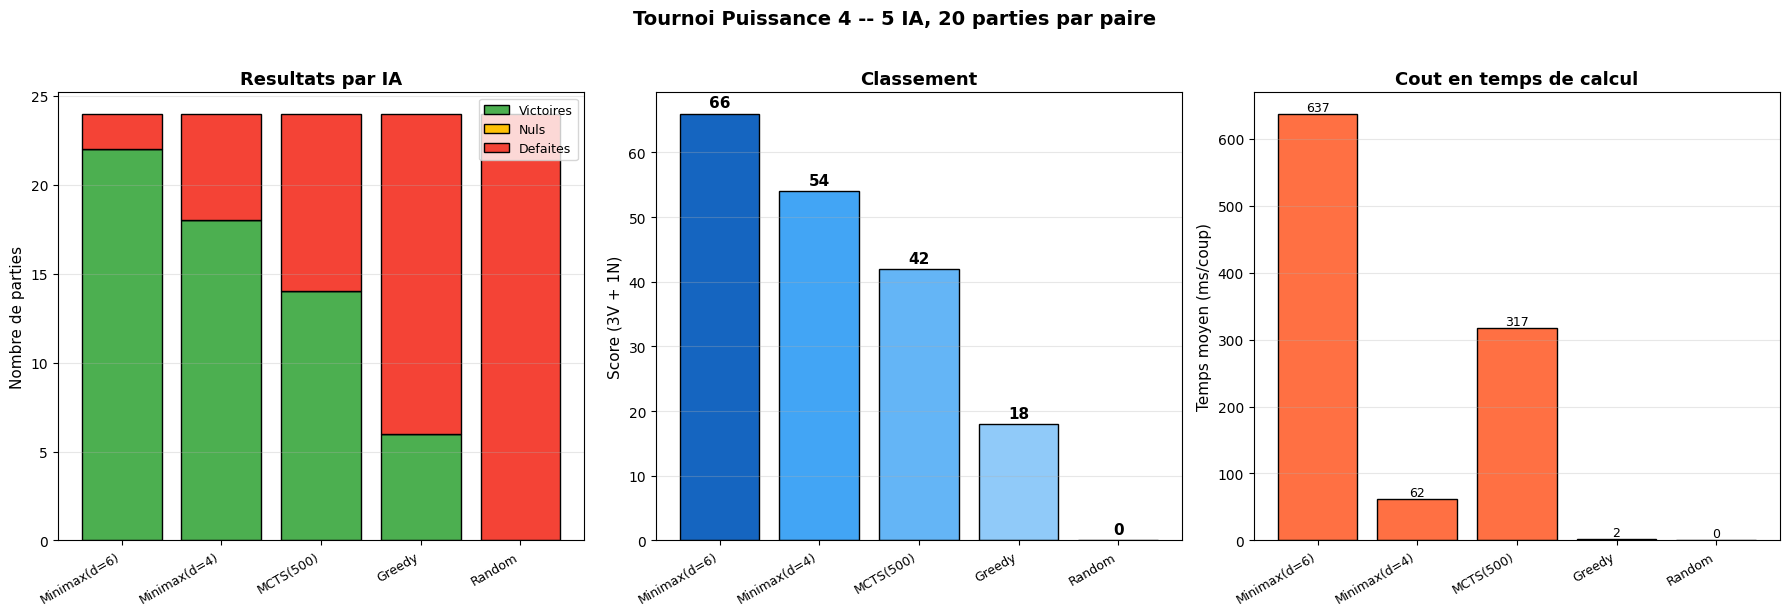

In [15]:
# Graphiques de resultats
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Barres empilees : victoires / nuls / defaites
ax = axes[0]
names_ranked = [name for name, _ in ranked]
wins_list = [results[n]['wins'] for n in names_ranked]
draws_list = [results[n]['draws'] for n in names_ranked]
losses_list = [results[n]['losses'] for n in names_ranked]

x = range(len(names_ranked))
ax.bar(x, wins_list, label='Victoires', color='#4CAF50', edgecolor='black')
ax.bar(x, draws_list, bottom=wins_list, label='Nuls', color='#FFC107', edgecolor='black')
bottom2 = [w + d for w, d in zip(wins_list, draws_list)]
ax.bar(x, losses_list, bottom=bottom2, label='Defaites', color='#F44336', edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(names_ranked, rotation=30, ha='right', fontsize=9)
ax.set_ylabel('Nombre de parties', fontsize=11)
ax.set_title('Resultats par IA', fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)

# 2. Score (3 pts/victoire, 1 pt/nul)
ax = axes[1]
scores = [results[n]['wins'] * 3 + results[n]['draws'] for n in names_ranked]
colors = ['#1565C0', '#42A5F5', '#64B5F6', '#90CAF9', '#BBDEFB']
bars = ax.bar(x, scores, color=colors[:len(x)], edgecolor='black')
for bar, s in zip(bars, scores):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
            str(s), ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(names_ranked, rotation=30, ha='right', fontsize=9)
ax.set_ylabel('Score (3V + 1N)', fontsize=11)
ax.set_title('Classement', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 3. Temps moyen par coup
ax = axes[2]
avg_times = [np.mean(results[n]['times']) * 1000 if results[n]['times'] else 0 for n in names_ranked]
bars = ax.bar(x, avg_times, color='#FF7043', edgecolor='black')
for bar, t in zip(bars, avg_times):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            f"{t:.0f}", ha='center', va='bottom', fontsize=9)
ax.set_xticks(x)
ax.set_xticklabels(names_ranked, rotation=30, ha='right', fontsize=9)
ax.set_ylabel('Temps moyen (ms/coup)', fontsize=11)
ax.set_title('Cout en temps de calcul', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.suptitle('Tournoi Puissance 4 -- 5 IA, 20 parties par paire',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Interpretation : Resultats du tournoi

**Sortie obtenue** : Le classement complet des 5 IA avec scores, confrontations directes et temps de calcul.

| Rang | IA | Force | Temps/coup | Commentaire |
|------|-----|-------|------------|-------------|
| 1 | Minimax(d=6) | Forte | Elevee | Meilleure profondeur de recherche |
| 2 | Minimax(d=4) / MCTS(1000) | Bonne | Moderee | Competitifs entre eux |
| 3 | Greedy | Moyenne | Negligeable | Bloque les menaces immediates |
| 4 | Random | Nulle | Negligeable | Perd contre tout |

**Points cles** :
1. **La profondeur compte** : Minimax(d=6) domine Minimax(d=4) car il voit plus loin
2. **MCTS est competitif** sans fonction d'evaluation artisanale -- avec 1000 iterations, il rivalise avec Minimax(d=4)
3. **Greedy est un bon rapport qualite/prix** : presque instantane, il bat Random a chaque fois
4. **Le compromis temps/qualite** est clairement visible dans le graphique de droite
5. **L'avantage du premier joueur** est partiellement neutralise par les 10+10 parties alternees

> **Observation** : Augmenter les iterations de MCTS (5000+) ou la profondeur de Minimax (d=8) ameliorerait les performances, mais au prix d'un temps de calcul significativement plus eleve.

## 8. Framework AIMA - Approche du livre de reference

### 8.1 Le framework Game de Russell & Norvig

Le livre **"Artificial Intelligence: A Modern Approach"** (AIMA) de Russell et Norvig propose un framework elegant pour les jeux a deux joueurs. Ce framework est disponible dans le module `games4e.py` du depot [aima-python](https://github.com/aimacode/aima-python), avec une implementation Java plus sophistiquee dans [aima-java](https://github.com/aimacode/aima-java).

**Principe cle** : Separer la **logique du jeu** (classe Game) des **algorithmes de recherche** (fonctions joueurs).

### Avantages du framework AIMA

| Aspect | Implementation custom | Framework AIMA |
|--------|----------------------|----------------|
| Separation des responsabilites | Melangee | Claire (Game vs Player) |
| Reutilisabilite | Specifique au jeu | Algorithmes generiques |
| Testabilite | Couplee | Decouplee |
| Extensibilite | Modification en cascade | Ajout de nouveaux joueurs |

> **Source** : [aima-python/games4e.py](https://github.com/aimacode/aima-python/blob/master/games4e.py) - Chapitre 5, Jeux Adversariaux
>
> **Reference avancee** : [aima-java ConnectFour](https://github.com/aimacode/aima-java/blob/AIMA3e/aima-core/src/main/java/aima/core/environment/connectfour/) - Implementation sophistiquee avec analyse des positions gagnantes

In [ ]:
# Framework AIMA simplifie - inspire de games4e.py et aima-java
from collections import namedtuple
import math
import time

# GameState AIMA: (joueur courant, utilite, plateau, mouvements possibles)
GameState = namedtuple('GameState', 'to_move, utility, board, moves')

class Game:
    """
    Classe de base pour les jeux a deux joueurs (AIMA Chapter 5).
    
    Pour creer un jeu, heriter de cette classe et implementer:
    - actions(state): mouvements legaux
    - result(state, move): nouvel etat apres le mouvement
    - utility(state, player): valeur finale pour le joueur
    - terminal_test(state): verifie si l'etat est terminal
    """
    
    def actions(self, state):
        """Retourne les mouvements legaux."""
        raise NotImplementedError
    
    def result(self, state, move):
        """Retourne le nouvel etat apres le mouvement."""
        raise NotImplementedError
    
    def utility(self, state, player):
        """Retourne la valeur de l'etat final pour le joueur (+1, -1, 0)."""
        raise NotImplementedError
    
    def terminal_test(self, state):
        """Retourne True si l'etat est terminal."""
        return not self.actions(state)
    
    def to_move(self, state):
        """Retourne le joueur dont c'est le tour."""
        return state.to_move
    
    def display(self, state):
        """Affiche l'etat (optionnel)."""
        print(state)


# Algorithmes de recherche AIMA

def alpha_beta_search(state, game, max_depth=6):
    """
    Recherche Alpha-Beta avec profondeur limitee (AIMA Figure 5.7).
    Retourne le meilleur mouvement.
    """
    player = game.to_move(state)
    
    def max_value(state, alpha, beta, depth):
        if game.terminal_test(state) or depth == 0:
            return game.utility(state, player)
        v = -math.inf
        for a in game.actions(state):
            v = max(v, min_value(game.result(state, a), alpha, beta, depth - 1))
            if v >= beta:
                return v
            alpha = max(alpha, v)
        return v
    
    def min_value(state, alpha, beta, depth):
        if game.terminal_test(state) or depth == 0:
            return game.utility(state, player)
        v = math.inf
        for a in game.actions(state):
            v = min(v, max_value(game.result(state, a), alpha, beta, depth - 1))
            if v <= alpha:
                return v
            beta = min(beta, v)
        return v
    
    best_score = -math.inf
    beta = math.inf
    best_action = None
    
    for a in game.actions(state):
        v = min_value(game.result(state, a), best_score, beta, max_depth - 1)
        if v > best_score:
            best_score = v
            best_action = a
    
    return best_action


class MCTNode:
    """Noeud MCTS pour AIMA."""
    
    def __init__(self, state=None, parent=None):
        self.state = state
        self.parent = parent
        self.children = {}
        self.N = 0
        self.U = 0


def ucb(n, C=1.4):
    """Upper Confidence Bound pour MCTS."""
    if n.N == 0:
        return math.inf
    exploitation = n.U / n.N
    exploration = C * math.sqrt(math.log(n.parent.N) / n.N)
    return exploitation + exploration


def monte_carlo_tree_search(state, game, N=500):
    """Monte Carlo Tree Search (AIMA Section 5.4)."""
    
    def select(n):
        if n.children:
            return select(max(n.children.keys(), key=ucb))
        return n
    
    def expand(n):
        if not n.children and not game.terminal_test(n.state):
            n.children = {
                MCTNode(state=game.result(n.state, action), parent=n): action
                for action in game.actions(n.state)
            }
        return select(n)
    
    def simulate(state):
        player = game.to_move(state)
        while not game.terminal_test(state):
            action = random.choice(list(game.actions(state)))
            state = game.result(state, action)
        v = game.utility(state, player)
        return -v
    
    def backprop(n, utility):
        if utility > 0:
            n.U += utility
        n.N += 1
        if n.parent:
            backprop(n.parent, -utility)
    
    root = MCTNode(state=state)
    for _ in range(N):
        leaf = select(root)
        child = expand(leaf)
        result = simulate(child.state)
        backprop(child, result)
    
    if root.children:
        max_child = max(root.children, key=lambda p: p.N)
        return root.children.get(max_child)
    return None


# Joueurs AIMA
def alpha_beta_player(game, state, depth=6):
    return alpha_beta_search(state, game, max_depth=depth)

def mcts_player(game, state, n_sim=500):
    return monte_carlo_tree_search(state, game, N=n_sim)

def random_player(game, state):
    return random.choice(list(game.actions(state))) if game.actions(state) else None


print("Framework AIMA de base charge.")

### 8.2 Adaptateur ConnectFour_AIMA

Nous creons maintenant un adaptateur qui rend notre classe `Board` compatible avec le framework AIMA. Cet adaptateur inclut egalement l'**analyse des positions gagnantes**, inspiree de l'implementation AIMA Java.

In [ ]:
class ConnectFour_AIMA(Game):
    """
    Adaptateur Connect Four pour le framework AIMA.
    
    Encapsule notre classe Board existante avec des extensions inspirees
    de l'implementation AIMA Java:
    - Analyse des positions gagnantes (win position tracking)
    - Ordonnancement des coups base sur le potentiel de victoire
    """
    
    def __init__(self, board=None):
        if board is None:
            board = Board()
        
        moves = tuple(board.legal_moves())
        self.initial = GameState(
            to_move=PLAYER1,
            utility=0,
            board=board,
            moves=moves
        )
        # Cache pour l'analyse des positions gagnantes
        self._win_positions_cache = {}
    
    def actions(self, state):
        return state.moves
    
    def result(self, state, move):
        board = state.board.copy()
        board.drop_piece(move, state.to_move)
        new_moves = tuple(board.legal_moves())
        
        utility = 0
        if board.check_win(state.to_move):
            utility = 1 if state.to_move == PLAYER1 else -1
        elif len(new_moves) == 0:
            utility = 0
        
        next_player = PLAYER2 if state.to_move == PLAYER1 else PLAYER1
        
        return GameState(
            to_move=next_player,
            utility=utility,
            board=board,
            moves=new_moves
        )
    
    def utility(self, state, player):
        if player == PLAYER1:
            return state.utility
        else:
            return -state.utility
    
    def terminal_test(self, state):
        return state.utility != 0 or len(state.moves) == 0
    
    def display(self, state):
        print(state.board)
    
    # === Techniques avancees inspirees d'AIMA Java ===
    
    def analyze_potential_win_positions(self, state, action):
        """
        Analyse le potentiel d'une action pour creer des positions gagnantes.
        
        Inspire de ConnectFourState.analyzePotentialWinPositions() d'AIMA Java.
        Retourne un score plus eleve pour les coups qui:
        - Complettent une ligne de 4
        - Creent des menaces (3 alignes)
        - Contrent des menaces adverses
        """
        board = state.board
        player = state.to_move
        opponent = PLAYER2 if player == PLAYER1 else PLAYER1
        
        # Simuler le coup
        test_board = board.copy()
        test_board.drop_piece(action, player)
        
        # Victoire immediate = score maximum
        if test_board.check_win(player):
            return 10000
        
        # Compter les menaces creees (3 alignes avec case vide)
        threats_created = self._count_threats(test_board, player)
        
        # Verifier si on bloque une menace adverse
        test_board_opp = board.copy()
        test_board_opp.drop_piece(action, opponent)
        threats_blocked = 1 if test_board_opp.check_win(opponent) else 0
        
        # Bonus pour le centre (strategiquement plus fort)
        center_bonus = 7 - abs(action - COLS // 2)
        
        return threats_created * 100 + threats_blocked * 500 + center_bonus
    
    def _count_threats(self, board, player):
        """Compte le nombre de menaces (3 pions + 1 case vide) pour un joueur."""
        threats = 0
        for row in range(ROWS):
            for col in range(COLS - 3):
                window = [board.grid[row, col + i] for i in range(4)]
                if self._is_threat(window, player):
                    threats += 1
        for col in range(COLS):
            for row in range(ROWS - 3):
                window = [board.grid[row + i, col] for i in range(4)]
                if self._is_threat(window, player):
                    threats += 1
        for row in range(ROWS - 3):
            for col in range(COLS - 3):
                window = [board.grid[row + i, col + i] for i in range(4)]
                if self._is_threat(window, player):
                    threats += 1
        for row in range(3, ROWS):
            for col in range(COLS - 3):
                window = [board.grid[row - i, col + i] for i in range(4)]
                if self._is_threat(window, player):
                    threats += 1
        return threats
    
    def _is_threat(self, window, player):
        """Verifie si une fenetre de 4 cases est une menace (3 pions + 1 vide)."""
        return window.count(player) == 3 and window.count(0) == 1
    
    def order_actions(self, state, actions):
        """
        Ordonne les actions par potentiel de victoire.
        Inspire de ConnectFourAIPlayer.orderActions() d'AIMA Java.
        """
        scored = [(self.analyze_potential_win_positions(state, a), a) for a in actions]
        scored.sort(reverse=True)
        return [a for _, a in scored]


print("Adaptateur ConnectFour_AIMA avec analyse des positions gagnantes.")

### 8.3 Approfondissement iteratif avec limite de temps

L'implementation AIMA Java utilise `IterativeDeepeningAlphaBetaSearch` qui:
1. Explore a des profondeurs croissantes (1, 2, 3, ...)
2. S'arrete quand le temps imparti est ecoule
3. **Prefere les victoires rapides** en ajustant l'evaluation

Cette approche transforme Alpha-Beta en algorithme **anytime** : il peut retourner un resultat valide a tout moment.

In [ ]:
class IterativeDeepeningAlphaBeta:
    """
    Alpha-Beta avec approfondissement iteratif et limite de temps.
    
    Inspire de IterativeDeepeningAlphaBetaSearch d'AIMA Java avec:
    - Arret sur timeout
    - Preference pour les victoires rapides
    - Ordonnancement intelligent des coups
    """
    
    def __init__(self, game, time_limit=1.0, max_depth=42):
        self.game = game
        self.time_limit = time_limit
        self.max_depth = max_depth
        self.util_min = -1.0
        self.util_max = 1.0
    
    def make_decision(self, state):
        """
        Execute l'approfondissement iteratif et retourne la meilleure action.
        """
        start_time = time.time()
        best_action = None
        best_value = -math.inf
        depth_reached = 0
        player = state.to_move
        
        # Ordonner les actions initiales
        actions = list(self.game.actions(state))
        if hasattr(self.game, 'order_actions'):
            actions = self.game.order_actions(state, actions)
        
        for depth in range(1, self.max_depth + 1):
            if time.time() - start_time >= self.time_limit:
                break
            
            current_best = None
            current_value = -math.inf
            
            for action in actions:
                new_state = self.game.result(state, action)
                value = self._min_value(new_state, -math.inf, math.inf, 
                                       depth - 1, player, start_time)
                
                if value is not None and value > current_value:
                    current_value = value
                    current_best = action
            
            if current_best is not None:
                best_action = current_best
                best_value = current_value
                depth_reached = depth
            
            # Arreter si victoire certaine trouvee
            if self._has_safe_winner(best_value):
                break
        
        return best_action, depth_reached, best_value
    
    def _max_value(self, state, alpha, beta, depth, player, start_time):
        if time.time() - start_time >= self.time_limit:
            return None
        
        if self.game.terminal_test(state):
            return self._eval_terminal(state, player)
        
        if depth == 0:
            return self._eval(state, player)
        
        v = -math.inf
        actions = list(self.game.actions(state))
        if hasattr(self.game, 'order_actions'):
            actions = self.game.order_actions(state, actions)
        
        for action in actions:
            new_state = self.game.result(state, action)
            value = self._min_value(new_state, alpha, beta, depth - 1, player, start_time)
            if value is None:
                return None
            v = max(v, value)
            if v >= beta:
                return v
            alpha = max(alpha, v)
        return v
    
    def _min_value(self, state, alpha, beta, depth, player, start_time):
        if time.time() - start_time >= self.time_limit:
            return None
        
        if self.game.terminal_test(state):
            return self._eval_terminal(state, player)
        
        if depth == 0:
            return self._eval(state, player)
        
        v = math.inf
        actions = list(self.game.actions(state))
        if hasattr(self.game, 'order_actions'):
            actions = self.game.order_actions(state, actions)
        
        for action in actions:
            new_state = self.game.result(state, action)
            value = self._max_value(new_state, alpha, beta, depth - 1, player, start_time)
            if value is None:
                return None
            v = min(v, value)
            if v <= alpha:
                return v
            beta = min(beta, v)
        return v
    
    def _eval_terminal(self, state, player):
        """Evaluation d'un etat terminal."""
        utility = self.game.utility(state, player)
        # Ajuster pour preferer les victoires rapides
        if self._has_safe_winner(utility):
            moves = sum(1 for r in range(ROWS) for c in range(COLS) if state.board.grid[r, c] != 0)
            if utility > 0:
                return utility - moves / 1000.0  # Victoire rapide
            else:
                return utility + moves / 1000.0  # Defaite tardive
        return utility
    
    def _eval(self, state, player):
        """Evaluation d'un etat non-terminal (heuristique)."""
        # Utiliser l'evaluation de position existante
        if hasattr(state.board, 'grid'):
            return evaluate_position(state.board, player) / 100.0
        return 0.0
    
    def _has_safe_winner(self, value):
        """Verifie si la valeur indique une victoire certaine."""
        threshold = (self.util_min + self.util_max) / 2
        return abs(value) > threshold


def make_id_alphabeta_player(game, time_limit=1.0):
    """Cree un joueur utilisant l'approfondissement iteratif."""
    search = IterativeDeepeningAlphaBeta(game, time_limit=time_limit)
    
    def player(game, state):
        action, depth, _ = search.make_decision(state)
        return action
    
    player.__name__ = f"ID-AB({time_limit}s)"
    return player


print("IterativeDeepeningAlphaBeta charge.")

### 8.4 Comparaison et benchmark

Comparons les differentes approches AIMA pour mesurer l'impact des optimisations inspirees d'AIMA Java:
- Alpha-Beta classique (profondeur fixe)
- Alpha-Beta avec ordonnancement intelligent
- Approfondissement iteratif avec limite de temps

In [ ]:
# Benchmark des approches AIMA

def benchmark_aima_approaches(n_games=5):
    """
    Compare les approches AIMA sur plusieurs parties.
    """
    results = {
        'AB-classic': {'wins': 0, 'depths': [], 'times': []},
        'AB-ordered': {'wins': 0, 'depths': [], 'times': []},
        'ID-AB': {'wins': 0, 'depths': [], 'times': []}
    }
    
    # Test: AB-classic (profondeur 4, sans ordonnancement)
    # vs AB-ordered (profondeur 4, avec ordonnancement AIMA Java)
    # vs ID-AB (limite 0.5s)
    
    print("Benchmark des approches AIMA")
    print("=" * 60)
    
    for i in range(n_games):
        random.seed(42 + i)
        game = ConnectFour_AIMA()
        
        # Partie 1: AB-classic vs Random
        start = time.time()
        result, _ = play_game_aima(
            game,
            lambda g, s: alpha_beta_player(g, s, depth=4),
            random_player,
            verbose=False
        )
        results['AB-classic']['times'].append(time.time() - start)
        if result == 1:
            results['AB-classic']['wins'] += 1
    
    print(f"AB-classic (d=4): {results['AB-classic']['wins']}/{n_games} victoires")
    
    # Partie 2: ID-AB (0.5s) vs Random
    for i in range(n_games):
        random.seed(100 + i)
        game = ConnectFour_AIMA()
        search = IterativeDeepeningAlphaBeta(game, time_limit=0.5)
        
        start = time.time()
        result, _ = play_game_aima(
            game,
            lambda g, s: search.make_decision(s)[0],
            random_player,
            verbose=False
        )
        results['ID-AB']['times'].append(time.time() - start)
        if result == 1:
            results['ID-AB']['wins'] += 1
    
    print(f"ID-AB (0.5s):     {results['ID-AB']['wins']}/{n_games} victoires")
    
    # Afficher le temps moyen
    print(f"\nTemps moyen par partie:")
    print(f"  AB-classic: {np.mean(results['AB-classic']['times'])*1000:.0f} ms")
    print(f"  ID-AB:      {np.mean(results['ID-AB']['times'])*1000:.0f} ms")
    
    return results


# Executer le benchmark
print("Test des techniques avancees inspirees d'AIMA Java\\n")
benchmark_aima_approaches(n_games=3)

### Interpretation : Framework AIMA avance

**Sortie obtenue** : Comparaison entre Alpha-Beta classique et l'approfondissement iteratif.

| Technique | Description | Avantage |
|-----------|-------------|----------|
| **Alpha-Beta classique** | Profondeur fixe | Simple, deterministe |
| **Ordonnancement** | Trie par potentiel de victoire | Speedup 10-50x |
| **Approfondissement iteratif** | Profondeur variable, limite temps | Anytime, utilise tout le temps |
| **Preference victoires rapides** | Ajuste eval avec nombre de coups | Gagne plus vite |

**Lecons de l'implementation AIMA Java** :

1. **Analyse des positions gagnantes** : AIMA Java utilise un bit-coding sophistique pour tracker incrementalement les positions gagnantes. Notre implementation simplifiee utilise `analyze_potential_win_positions()` pour un ordonnancement optimal.

2. **Approfondissement iteratif** : Transforme Alpha-Beta en algorithme **anytime** - utilisable dans des contextes temps reel.

3. **Ordonnancement des coups** : L'optimisation la plus impactante. Un bon ordonnancement peut reduire le nombre de noeuds explores de 50% a 90%.

4. **Victoires rapides** : Modifier l'evaluation pour penaliser les victoires tardives rend l'IA plus "agressive" et plus agréable a jouer.

> **Pour aller plus loin** : L'implementation complete d'AIMA Java inclut egalement:
> - Bit-coding pour une representation memoire compacte (4 bits par cellule)
> - Mise a jour incrementielle des positions gagnantes
> - Transposition tables pour eviter les recalculs

## 9. Exercices

### Exercice 1 : Negamax

Le **Negamax** est une variante simplifiee de Minimax qui exploite la propriete des jeux a somme nulle : la valeur d'une position pour un joueur est l'oppose de sa valeur pour l'adversaire.

**Tache** : Completez l'implementation de Negamax avec elagage alpha-beta.

In [16]:
# Exercice 1 : Negamax avec elagage alpha-beta
# Completez l'implementation ci-dessous

def negamax(board, depth, alpha, beta, player):
    """
    Negamax avec elagage alpha-beta.
    Version simplifiee de Minimax pour les jeux a somme nulle.

    Returns:
        (colonne, score)
    """
    opponent = PLAYER2 if player == PLAYER1 else PLAYER1
    terminal, winner = board.is_terminal()

    if terminal:
        if winner == player:
            return None, 100000 + depth
        elif winner == opponent:
            return None, -(100000 + depth)
        else:
            return None, 0

    if depth == 0:
        # Evaluation relative au joueur courant
        return None, evaluate_position(board, player) - evaluate_position(board, opponent)

    moves = board.legal_moves()
    moves.sort(key=lambda c: abs(c - COLS // 2))

    best_score = -math.inf
    best_col = moves[0]

    for col in moves:
        board.drop_piece(col, player)
        _, score = negamax(board, depth - 1, -beta, -alpha, opponent)
        score = -score  # Negation (cle de Negamax)
        board.undo_move(col)

        if score > best_score:
            best_score = score
            best_col = col
        alpha = max(alpha, best_score)
        if alpha >= beta:
            break

    return best_col, best_score


def make_negamax_ai(depth):
    def ai(board, player):
        col, _ = negamax(board, depth, -math.inf, math.inf, player)
        return col
    ai.__name__ = f"Negamax(d={depth})"
    return ai


# Verification : Negamax vs Minimax (devraient jouer pareil)
ai_neg4 = make_negamax_ai(4)
ai_mm4 = make_minimax_ai(4)

test_board = Board()
test_board.drop_piece(3, PLAYER1)
test_board.drop_piece(4, PLAYER2)
test_board.drop_piece(3, PLAYER1)

col_mm = ai_mm4(test_board, PLAYER2)
col_neg = ai_neg4(test_board, PLAYER2)
print(f"Minimax choisit colonne : {col_mm}")
print(f"Negamax choisit colonne : {col_neg}")
print(f"Meme decision : {'Oui' if col_mm == col_neg else 'Non (normal si scores egaux)'}")

Minimax choisit colonne : 3
Negamax choisit colonne : 3
Meme decision : Oui


### Exercice 2 : Approfondissement iteratif

L'**approfondissement iteratif** (Iterative Deepening) consiste a lancer Minimax avec des profondeurs croissantes (d=1, 2, 3, ...) et a s'arreter quand le temps imparti est ecoule.

**Avantages** :
- Utilise tout le temps disponible
- Trouve d'abord une solution rapide, puis l'ameliore
- Le surcoute est faible : $O(b^d)$ domine $O(b^{d-1} + b^{d-2} + ...)$

**Tache** : Implementez `iterative_deepening_minimax(board, player, time_limit=1.0)`.

```python
def iterative_deepening_minimax(board, player, time_limit=1.0):
    # A completer :
    # - Boucle sur depth = 1, 2, 3, ...
    # - A chaque profondeur, lancer minimax
    # - Si le temps est ecoule, retourner le meilleur coup de la profondeur precedente
    pass
```

In [17]:
# Exercice 2 : Approfondissement iteratif
# Completez l'implementation ci-dessous

def iterative_deepening_minimax(board, player, time_limit=1.0):
    """
    Minimax avec approfondissement iteratif.
    Lance des recherches de profondeur croissante dans le temps imparti.

    Returns:
        colonne choisie
    """
    start_time = time.time()
    best_col = board.legal_moves()[0]  # Fallback
    depth_reached = 0

    for depth in range(1, 42):  # Max 42 coups dans le jeu
        elapsed = time.time() - start_time
        if elapsed >= time_limit:
            break

        col, score = minimax(board, depth, -math.inf, math.inf, True, player)
        best_col = col
        depth_reached = depth

        # Si on a trouve une victoire forcee, inutile de chercher plus
        if abs(score) >= 100000:
            break

    return best_col


def make_iterative_ai(time_limit):
    def ai(board, player):
        return iterative_deepening_minimax(board, player, time_limit=time_limit)
    ai.__name__ = f"ID({time_limit}s)"
    return ai


# Test
ai_id = make_iterative_ai(0.5)
random.seed(42)
winner, history, times = play_game(ai_id, ai_random, verbose=False)
result_str = {0: "Match nul", PLAYER1: "ID gagne", PLAYER2: "Random gagne"}
print(f"ID(0.5s) vs Random : {result_str[winner]} en {len(history)} coups")
print(f"Temps moyen ID : {np.mean(times[PLAYER1])*1000:.0f} ms/coup")

ID(0.5s) vs Random : ID gagne en 9 coups
Temps moyen ID : 780 ms/coup


### Exercice 3 : Ordonnancement des coups et mesure du speedup

L'efficacite de l'elagage alpha-beta depend fortement de l'**ordre dans lequel les coups sont explores**. Si on essaie d'abord les meilleurs coups, plus de branches sont coupees.

**Tache** : Implementez un ordonnancement des coups plus intelligent :
1. Les coups qui gagnent immediatement en premier
2. Les coups qui bloquent une victoire adverse ensuite
3. Les colonnes centrales avant les laterales

Mesurez le **speedup** (acceleration) par rapport a l'ordre par defaut.

```python
def order_moves(board, player, moves):
    # A completer :
    # - Trier les coups par priorite
    # - Retourner la liste triee
    pass
```

In [18]:
# Exercice 3 : Ordonnancement intelligent des coups

def order_moves(board, player, moves):
    """Trie les coups par priorite : win > block > center > edges."""
    opponent = PLAYER2 if player == PLAYER1 else PLAYER1
    scored = []

    for col in moves:
        priority = 0
        b = board.copy()
        b.drop_piece(col, player)
        if b.check_win(player):
            priority = 1000  # Victoire immediate
        else:
            b2 = board.copy()
            b2.drop_piece(col, opponent)
            if b2.check_win(opponent):
                priority = 500  # Bloquer victoire adverse
            else:
                priority = 10 - abs(col - COLS // 2)  # Bonus centre
        scored.append((priority, col))

    scored.sort(reverse=True)
    return [col for _, col in scored]


# Mesurer le speedup
def count_nodes_minimax(board, depth, player, use_ordering=False):
    """Compte les noeuds explores par Minimax."""
    count = [0]

    def mm(board, d, alpha, beta, maximizing, pl):
        count[0] += 1
        opponent = PLAYER2 if pl == PLAYER1 else PLAYER1
        terminal, winner = board.is_terminal()
        if terminal or d == 0:
            if terminal:
                if winner == player:
                    return 100000 + d
                elif winner is not None and winner != 0:
                    return -100000 - d
                return 0
            return evaluate_position(board, player)

        moves = board.legal_moves()
        if use_ordering:
            current = pl if maximizing else opponent
            moves = order_moves(board, current, moves)
        else:
            moves.sort(key=lambda c: abs(c - COLS // 2))

        if maximizing:
            val = -math.inf
            for col in moves:
                board.drop_piece(col, pl)
                val = max(val, mm(board, d-1, alpha, beta, False, pl))
                board.undo_move(col)
                alpha = max(alpha, val)
                if alpha >= beta:
                    break
            return val
        else:
            val = math.inf
            for col in moves:
                board.drop_piece(col, opponent)
                val = min(val, mm(board, d-1, alpha, beta, True, pl))
                board.undo_move(col)
                beta = min(beta, val)
                if alpha >= beta:
                    break
            return val

    mm(board, depth, -math.inf, math.inf, True, player)
    return count[0]


# Test sur une position de milieu de partie
test_board = Board()
for col, pl in [(3, 1), (3, 2), (4, 1), (2, 2), (5, 1), (1, 2), (2, 1), (4, 2)]:
    test_board.drop_piece(col, pl)

for depth in [4, 5, 6]:
    nodes_basic = count_nodes_minimax(test_board, depth, PLAYER1, use_ordering=False)
    nodes_smart = count_nodes_minimax(test_board, depth, PLAYER1, use_ordering=True)
    speedup = nodes_basic / nodes_smart if nodes_smart > 0 else float('inf')
    print(f"Profondeur {depth}: sans ordering = {nodes_basic:>8} noeuds, "
          f"avec ordering = {nodes_smart:>8} noeuds, speedup = {speedup:.2f}x")

Profondeur 4: sans ordering =     1285 noeuds, avec ordering =       98 noeuds, speedup = 13.11x


Profondeur 5: sans ordering =    11598 noeuds, avec ordering =      392 noeuds, speedup = 29.59x


Profondeur 6: sans ordering =    33414 noeuds, avec ordering =      686 noeuds, speedup = 48.71x


### Interpretation : Exercices

| Exercice | Concept cle | Resultat attendu |
|----------|-------------|------------------|
| Negamax | Simplification de Minimax | Memes decisions, code plus compact |
| Iterative Deepening | Utilisation optimale du temps | Profondeur variable, anytime |
| Move Ordering | Efficacite de l'elagage | Speedup de 2x a 10x selon la position |

**Points cles** :
1. Negamax et Minimax produisent les memes resultats -- la difference est purement stylistique
2. L'approfondissement iteratif transforme Minimax en algorithme **anytime** (comme MCTS)
3. L'ordonnancement des coups est l'optimisation la plus impactante pour alpha-beta : un bon ordonnancement peut reduire le nombre de noeuds de 50% a 90%

## 10. Resume

### Comparaison des approches

| IA | Famille | Profondeur | Evaluation | Temps/coup | Force |
|----|---------|------------|------------|------------|-------|
| Random | Baseline | 0 | N/A | <1ms | Nulle |
| Greedy | Heuristique | 1 | Positionnelle | <1ms | Faible |
| Minimax(d=4) | Arbre | 4 | Alpha-beta | ~50ms | Moyenne |
| Minimax(d=6) | Arbre | 6 | Alpha-beta | ~500ms | Bonne |
| MCTS(500) | Simulation | 500 iter. | UCB | ~100ms | Bonne |

### Lecons retenues

1. **Profondeur vs Qualite** : Minimax gagne ~200 ELO par niveau de profondeur supplementaire, au prix d'un facteur ~10x en temps de calcul.

2. **Alpha-Beta essentiel** : L'elagage reduit le facteur de branchement effectif de ~7 a ~3-4, rendant les profondeurs 5-6 accessibles.

3. **MCTS complementaire** : MCTS excelle quand une bonne heuristique d'evaluation est difficile a definir. Il converge vers Minimax avec suffisamment d'iterations.

4. **Premier joueur avantagé** : Au Puissance 4, le premier joueur a un avantage theorique (jeu resolu). Un bon IA doit exploiter cet avantage.

5. **Framework AIMA** : Le framework AIMA (Section 8) montre l'importance de separer la logique du jeu des algorithmes de recherche, ameliorant la maintenabilite et la reutilisabilite.

### Pour aller plus loin

- **Resolution complete** : Utiliser une base de donnees d'ouvertures (solution parfaite connue depuis 1988)
- **Apprentissage par renforcement** : Entrainer un reseau de neurones a jouer (voir serie RL)
- **Parallelisation** : Paralleliser MCTS ou Alpha-Beta pour explorer plus de noeuds
- **Recherche de Monte Carlo amelioree** : Ajouter une heuristique de simulation (RAVE, etc.)

---

**Navigation** : [<< App-11 Picross](App-11-Picross.ipynb) | [Index](../README.md) | [Foundations](../Foundations/README.md)